In [1]:
# Imports
from singlelaser.create_singlelaser_files import generate_event_files

import os
import numpy as np
from scipy import interpolate
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import dill as pickle
from datetime import date, datetime
from astropy.io import fits
from scipy import linalg
from scipy.interpolate import griddata

font = {'size' : 16, 'family' : 'sans-serif'}
matplotlib.rc('font', **font)

saa_axis = np.arange(0,180,0.2)
time_axis = np.arange(0.7e8,3.5e8,1e6)

interpolator_path = '../interpolators'

singlelaser_results_file = '/Users/hannah/Dropbox/PhD/Ops/testbed/singlelaser_results.fits'
slres = fits.open(singlelaser_results_file)
singlelaser_results = slres[1].data
fpma = singlelaser_results['MOD'] == 'A'
mode = singlelaser_results['MODE']
saa = singlelaser_results['SAA']
slres.close()

interpolators = ['baseline','translation_angle','sine_amp','sine_mean','phase_diff',
                'x_amp_diff_0to1','x_amp_diff_1to0','y_amp_diff_0to1','y_amp_diff_1to0']

# Parameters for querying results table
fields = ['BASELINE','ANGLE','AMP','AMP_OFFSET','PHASE_DIFF',
          'X_DIFF_ACTUAL','X_DIFF_ACTUAL','Y_DIFF_ACTUAL','Y_DIFF_ACTUAL']
use_mode = ['01','01','01','01','01','07','08','07','08']

print("Interpolators: ", interpolators)

Interpolators:  ['baseline', 'translation_angle', 'sine_amp', 'sine_mean', 'phase_diff', 'x_amp_diff_0to1', 'x_amp_diff_1to0', 'y_amp_diff_0to1', 'y_amp_diff_1to0']


In [2]:
# Set the relation we want to update from the interpolators list above
relation = 'baseline'

# Define filenames etc.
filename = f'{relation}_interpolator.pkl'
today = date.today().strftime('%Y%m%d')
archive_filename = f'{relation}_interpolator_{today}.pkl'
idx = interpolators.index(relation)

print(filename, archive_filename, idx)

# Load up relevant data for this relation
pick_value = fpma & (mode == use_mode[idx])
this_parameter = singlelaser_results[fields[idx]][pick_value]
this_saa = saa[pick_value]
this_date = np.array([datetime.fromisoformat(x) for x in singlelaser_results['DATE'][pick_value]])
this_met = np.array([t.total_seconds() for t in (this_date - datetime.strptime('2010-01-01','%Y-%m-%d'))]) # i.e. MET

# Sort by date for plotting
date_sort = np.argsort(this_date)
this_parameter, this_saa, this_date, this_met = this_parameter[date_sort], this_saa[date_sort], this_date[date_sort], this_met[date_sort]

startnum = mdates.date2num(this_date)
startnorm = matplotlib.colors.Normalize(vmin=np.min(startnum),vmax=np.max(startnum))
startmap = matplotlib.cm.ScalarMappable(norm=startnorm,cmap='viridis')

# Sort by SAA for spline fitting
saa_sort = np.argsort(this_saa)
this_parameter_s, this_saa_s, this_date_s = this_parameter[saa_sort], this_saa[saa_sort], this_date[saa_sort]

old_spline_function = pickle.load(open(os.path.join(interpolator_path,filename), 'rb'))


baseline_interpolator.pkl baseline_interpolator_20250206.pkl 0


[ 8.01297965e+02 -6.02715867e-03  2.51333967e-01 -1.89996342e-04
  1.65107970e-04  6.22464144e-07 -9.53696355e-09 -6.99770829e-03
 -6.09277862e-07  6.77565408e-05]


/var/folders/29/6vcft0290vd4cy_p4gxt4f2w0000gn/T/ipykernel_97358/1743895900.py:93: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=-0.3,vmax=0.3),cmap='RdBu_r'), location='right', label='Residuals', shrink=0.6)
/var/folders/29/6vcft0290vd4cy_p4gxt4f2w0000gn/T/ipykernel_97358/1743895900.py:94: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/29/6vcft0290vd4cy_p4gxt4f2w0000gn/T/ipykernel_97358/1743895900.py:124: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argu

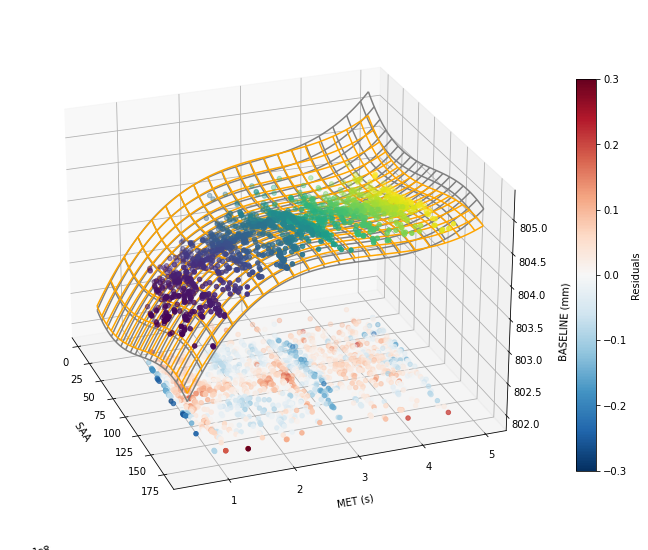

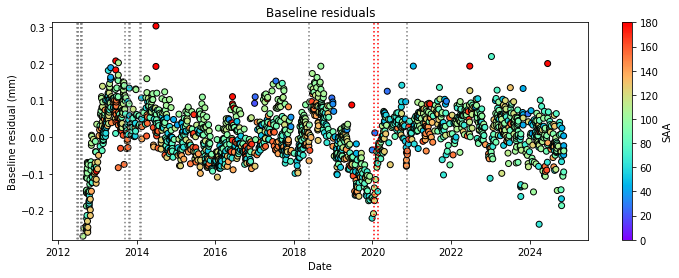

In [72]:
# This is to use as a starting point - modify one of the below until it produces a better fit than you started with:
# 
# new_spline_function = interpolate.UnivariateSpline(this_saa, this_parameter, ext=3, s=1)
# A good starting point for smoothing factor s is len(this_saa_s), then reduce until fit is better
# You may need to filter the input points for this, or define different SAA ranges to treat differently
#
# def estimate_baseline(this_saa, this_met):
#    x, y = this_saa, this_met/1.e7 # MET was divided by 1e7 to make fitting the polynomial easier
#    p00, p10, p01, p11, p20, p21, p12, p02, p30 = [8.02e2, -2.08e-2, 1.37e-1, 2.45e-4, 2.68e-4,
#                                                   -5.62e-8, -6.94e-6, -2.16e-3, -8.84e-7]
#    return p00 + p10*x + p01*y + p11*x*y + p20*x**2 + p21*x**2*y + p12*x*y**2 + p02*y**2 + p30*x**3

# Plot the current relation
if relation == 'baseline':
    
    x = this_saa[np.isfinite(this_parameter)]
    y = this_met[np.isfinite(this_parameter)]
    z = this_parameter[np.isfinite(this_parameter)]
    
    # Fit a 2D polynomial to the baseline
    data = np.c_[x,y/1.e7,z]
    lin_x, lin_y = np.linspace(0,180,181), np.linspace(5,50,451)
    grid_x, grid_y = np.meshgrid(lin_x, lin_y)
    grid_z = griddata(np.c_[x,y/1.e7], z, (grid_x, grid_y), method='linear')
    
    # Option 1: third order polynomial in x, second order in y
    def _polynomial(M, params):
        xx, yy = M
        p00, p10, p01, p11, p20, p21, p12, p02, p30 = params
        return p00 + p10*xx + p01*yy + p11*xx*yy + p20*xx**2 + p21*xx**2*yy + p12*xx*yy**2 + p02*yy**2 + p30*xx**3
    
    A1 = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,0]**2,
               np.prod(np.c_[data[:,0]**2, data[:,1]], axis=1), np.prod(np.c_[data[:,0], data[:,1]**2], axis=1),
               data[:,1]**2, data[:,0]**3]
    
    # Option 2: third order polynomial in x, third order in y
    def _polynomial2(M, params):
        xx, yy = M
        p00, p10, p01, p11, p20, p21, p12, p02, p30, p03 = params
        return p00 + p10*xx + p01*yy + p11*xx*yy + p20*xx**2 + p21*xx**2*yy + p12*xx*yy**2 + p02*yy**2 + p30*xx**3 + p03*yy**3

    A2 = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,0]**2,
               np.prod(np.c_[data[:,0]**2, data[:,1]], axis=1), np.prod(np.c_[data[:,0], data[:,1]**2], axis=1),
               data[:,1]**2, data[:,0]**3, data[:,1]**3]
    
    soln, r, _, _ = linalg.lstsq(A2, data[:,2])
    grid_z2 = _polynomial2((grid_x,grid_y),soln)
    residuals = z - _polynomial2((x,y/1.e7),soln)
    print(soln)
    
    # Note from 2025-02-06: Not necessary at this time but may be needed in the future to fit additional curvature
    # Option 3: third order polynomial in x, fourth(!) order in y
    def _polynomial3(M, params):
        xx, yy = M
        p00, p10, p01, p11, p20, p21, p12, p02, p30, p03, p04 = params
        return p00 + p10*xx + p01*yy + p11*xx*yy + p20*xx**2 + p21*xx**2*yy + p12*xx*yy**2 + p02*yy**2 + p30*xx**3 + p03*yy**3 + p04*yy**4

    A3 = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,0]**2,
               np.prod(np.c_[data[:,0]**2, data[:,1]], axis=1), np.prod(np.c_[data[:,0], data[:,1]**2], axis=1),
               data[:,1]**2, data[:,0]**3, data[:,1]**3, data[:,1]**4]
    
    
    # Create the new function explicitly in here
    # Needs to be hard-coded for pickling purposes
    def new_estimate_baseline(saa_array, met_array):
        x, y = saa_array, met_array/1.e7 # MET was divided by 1e7 to make fitting the polynomial easier
        
        # Space to enter the solution hardcoded for pickling
        
        # Solution for 2025-02-06
        p00, p10, p01, p11, p20, p21, p12, p02, p30, p03 = [8.0129e+02, -6.0272e-03,  2.5133e-01, -1.8999e-04, 1.6510e-04, 6.2246e-07, -9.5369e-09, -6.9977e-03, -6.0927e-07, 6.7756e-05]

        # Solution for 2023-01-27
        #p00, p10, p01, p11, p20, p21, p12, p02, p30, p03 = [8.011e2, -7.258e-3, 2.826e-1, -1.595e-4, 1.758e-4,
        #                                                   6.023e-7, -6.627e-7, -8.548e-3, -6.443e-7, 9.083e-5]
        return p00 + p10*x + p01*y + p11*x*y + p20*x**2 + p21*x**2*y + p12*x*y**2 + p02*y**2 + p30*x**3 + p03*y**3
    
    # 3D plot of baseline vs SAA and time
    lin_x_plot, lin_y_plot = np.linspace(0,180,181), np.linspace(5,50,451)*1.e7
    grid_x_plot, grid_y_plot = np.meshgrid(lin_x_plot, lin_y_plot)
    grid_z_plot_old = old_spline_function(grid_x_plot, grid_y_plot)
    #residuals = z - old_spline_function(x,y)
    grid_z_plot = new_estimate_baseline(grid_x_plot, grid_y_plot)
    residuals = z - new_estimate_baseline(x,y)
    
    fig = plt.figure(figsize=[12,12])
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.view_init(25, 340)
    ax.plot_wireframe(grid_x_plot, grid_y_plot, grid_z_plot_old, color='gray', rcount=20, ccount=20)
    ax.plot_wireframe(grid_x_plot, grid_y_plot, grid_z_plot, color='orange', rcount=20, ccount=20)
    ax.scatter3D(x,y,z,c=y,cmap=plt.cm.viridis)
    cr = ax.scatter3D(x,y,[802]*len(residuals),c=residuals,cmap='RdBu_r',norm=matplotlib.colors.Normalize(vmin=-0.3,vmax=0.3))
    #ax.set_zlim([802,805])
    ax.set_xlabel('\nSAA     ')
    ax.set_ylabel('\nMET (s)')
    ax.set_zlabel('\n\nBASELINE (mm)')
    plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=-0.3,vmax=0.3),cmap='RdBu_r'), location='right', label='Residuals', shrink=0.6)
    fig.show()
    
    # Also plot residuals with time
    saanorm = matplotlib.colors.Normalize(vmin=0,vmax=180)
    saamap = matplotlib.cm.ScalarMappable(norm=saanorm,cmap='rainbow')
    
    plt.figure(figsize=[12,4])
    plt.title('Baseline residuals')
    plt.scatter(this_date[np.isfinite(this_parameter)],residuals,marker='o',edgecolors='k',c=x,cmap='rainbow',norm=saanorm)
    # MAM events
    plt.plot([datetime(2012,6,22),datetime(2012,6,22)],[-0.4,0.4],ls=':',color='grey')
    plt.plot([datetime(2012,6,29),datetime(2012,6,29)],[-0.4,0.4],ls=':',color='grey')
    plt.plot([datetime(2012,7,1),datetime(2012,7,1)],[-0.4,0.4],ls=':',color='grey')
    plt.plot([datetime(2012,7,27),datetime(2012,7,27)],[-0.4,0.4],ls=':',color='grey')
    plt.plot([datetime(2012,8,3),datetime(2012,8,3)],[-0.4,0.4],ls=':',color='grey')
    plt.plot([datetime(2012,8,6),datetime(2012,8,6)],[-0.4,0.4],ls=':',color='grey')
    plt.plot([datetime(2013,9,17),datetime(2013,9,17)],[-0.4,0.4],ls=':',color='grey')
    plt.plot([datetime(2013,10,22),datetime(2013,10,22)],[-0.4,0.4],ls=':',color='grey')
    plt.plot([datetime(2013,10,25),datetime(2013,10,25)],[-0.4,0.4],ls=':',color='grey')
    plt.plot([datetime(2014,2,3),datetime(2014,2,3)],[-0.4,0.4],ls=':',color='grey')
    plt.plot([datetime(2014,2,13),datetime(2014,2,13)],[-0.4,0.4],ls=':',color='grey')
    plt.plot([datetime(2018,5,22),datetime(2018,5,22)],[-0.4,0.4],ls=':',color='grey')
    plt.plot([datetime(2020,11,17),datetime(2020,11,17)],[-0.4,0.4],ls=':',color='grey')
    # Heater adjustments
    plt.plot([datetime(2020,1,14),datetime(2020,1,14)],[-0.4,0.4],ls=':',color='red')
    plt.plot([datetime(2020,2,19),datetime(2020,2,19)],[-0.4,0.4],ls=':',color='red')
    
    plt.ylim([min(residuals)-0.01,max(residuals)+0.01])
    plt.xlabel('Date')
    plt.ylabel('Baseline residual (mm)')
    plt.colorbar(saamap, location='right',label='SAA')
    plt.show()
    plt.close()
    
else:
    # Remove data points that aren't helping
    saa_filter = ~(((this_saa_s > 64) & (this_saa_s < 66.5) & (this_parameter_s > -0.5)) | ((this_saa_s > 74) & (this_saa_s < 76.5) & (this_parameter_s > -1)) | ((this_saa_s > 78) & (this_saa_s < 80) & (this_parameter_s < -0.5)) | ((this_saa_s > 114) & (this_saa_s < 116) & (this_parameter_s > -1.5)) | ((this_saa_s > 61) & (this_saa_s < 63) & (this_parameter_s < -1.5)) | ((this_saa_s > 66) & (this_saa_s < 73) & (this_parameter_s < -1.5)))
    new_spline_function = interpolate.UnivariateSpline(this_saa_s[saa_filter], this_parameter_s[saa_filter], ext=3, s=95)
    
    # Spline plot of relation vs SAA
    plt.figure(figsize=[18,8])
    
    plt.scatter(this_saa, this_parameter, c=startnum, marker='o',edgecolors='k',cmap='viridis',norm=startnorm)
    plt.plot(saa_axis,old_spline_function(saa_axis),c='r')
    plt.plot(saa_axis,new_spline_function(saa_axis),c='orange',ls='--')
    plt.colorbar(startmap, location='right', label='Date', 
                 ticks=mdates.YearLocator(),format=mdates.DateFormatter('%Y'))
    plt.xlabel('SAA')
    plt.ylabel(fields[idx])
    plt.xlim([0,180])
    plt.show()
    plt.close()
    
    # Residuals, old and new
    plt.figure(figsize=[18,8])
    plt.subplot(2,1,1)
    plt.scatter(this_saa, this_parameter - old_spline_function(this_saa), c=startnum, marker='o',edgecolors='k',cmap='viridis',norm=startnorm)
    plt.plot([0,180],[0,0],c='grey')
    plt.colorbar(startmap, location='right', label='Date', format=mdates.DateFormatter('%Y'))
    plt.xlim([0,180])
    plt.ylabel(fields[idx])
    
    plt.subplot(2,1,2)
    plt.scatter(this_saa, this_parameter - new_spline_function(this_saa), c=startnum, marker='o',edgecolors='k',cmap='viridis',norm=startnorm)
    plt.plot([0,180],[0,0],c='grey')
    plt.colorbar(startmap, location='right', label='Date', format=mdates.DateFormatter('%Y'))
    plt.xlim([0,180])
    plt.xlabel('SAA')
    plt.ylabel(fields[idx])
    
    plt.show()
    plt.close()

In [73]:
# Pickle and save your new relation to the archive folder (but don't replace the main file yet)
if relation == 'baseline':
    # Pickle the function
    with open(os.path.join(interpolator_path,'archive',archive_filename), 'wb') as f:
        pickle.dump(new_estimate_baseline, f)
else:
    # Pickle the function
    with open(os.path.join(interpolator_path,'archive',archive_filename), 'wb') as f:
        pickle.dump(new_spline_function, f)

# Repeat for whichever relations you want to update